# Imperial AI & ML Capstone Project  
Submission by: **Andrew Major**  
Student Number: **432**
## Initial Setup and Data Exploration  


In [1]:
import numpy as np
import pandas as pd
import decimal
from termcolor import colored
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import capstoneFunctions as cf

from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler

#### Load the dataset from .csv file  
Explore columns and missing data

In [2]:
rawData = pd.read_csv('./data/churn_modelling.csv')

In [3]:
rawData.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
rawData.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Now look for the missing values...

In [5]:
np.where(pd.isnull(rawData))

(array([], dtype=int64), array([], dtype=int64))

We can drop any irrelevant columns unlikely to influence outcome...

In [6]:
rawData = rawData.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Muli-value categorical columns need to be 'one hot' encoded

In [7]:
encodedData = pd.get_dummies(rawData,drop_first=True)
encodedData

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


Split the data into predictors and outcomes, in preparation for creation of training, test and validation sets

In [8]:
predictors = encodedData.drop(columns=['Exited'])
outcomes = encodedData['Exited']

Check the distribution of outcomes, as this will influence our choice of performance metrics for the models later.

In [9]:
outcomes.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The target of positive churn represents approximately 20% of the total dataset

#### Plot Correlation Matix  
We need to determine if multi-colinearity will be an issue

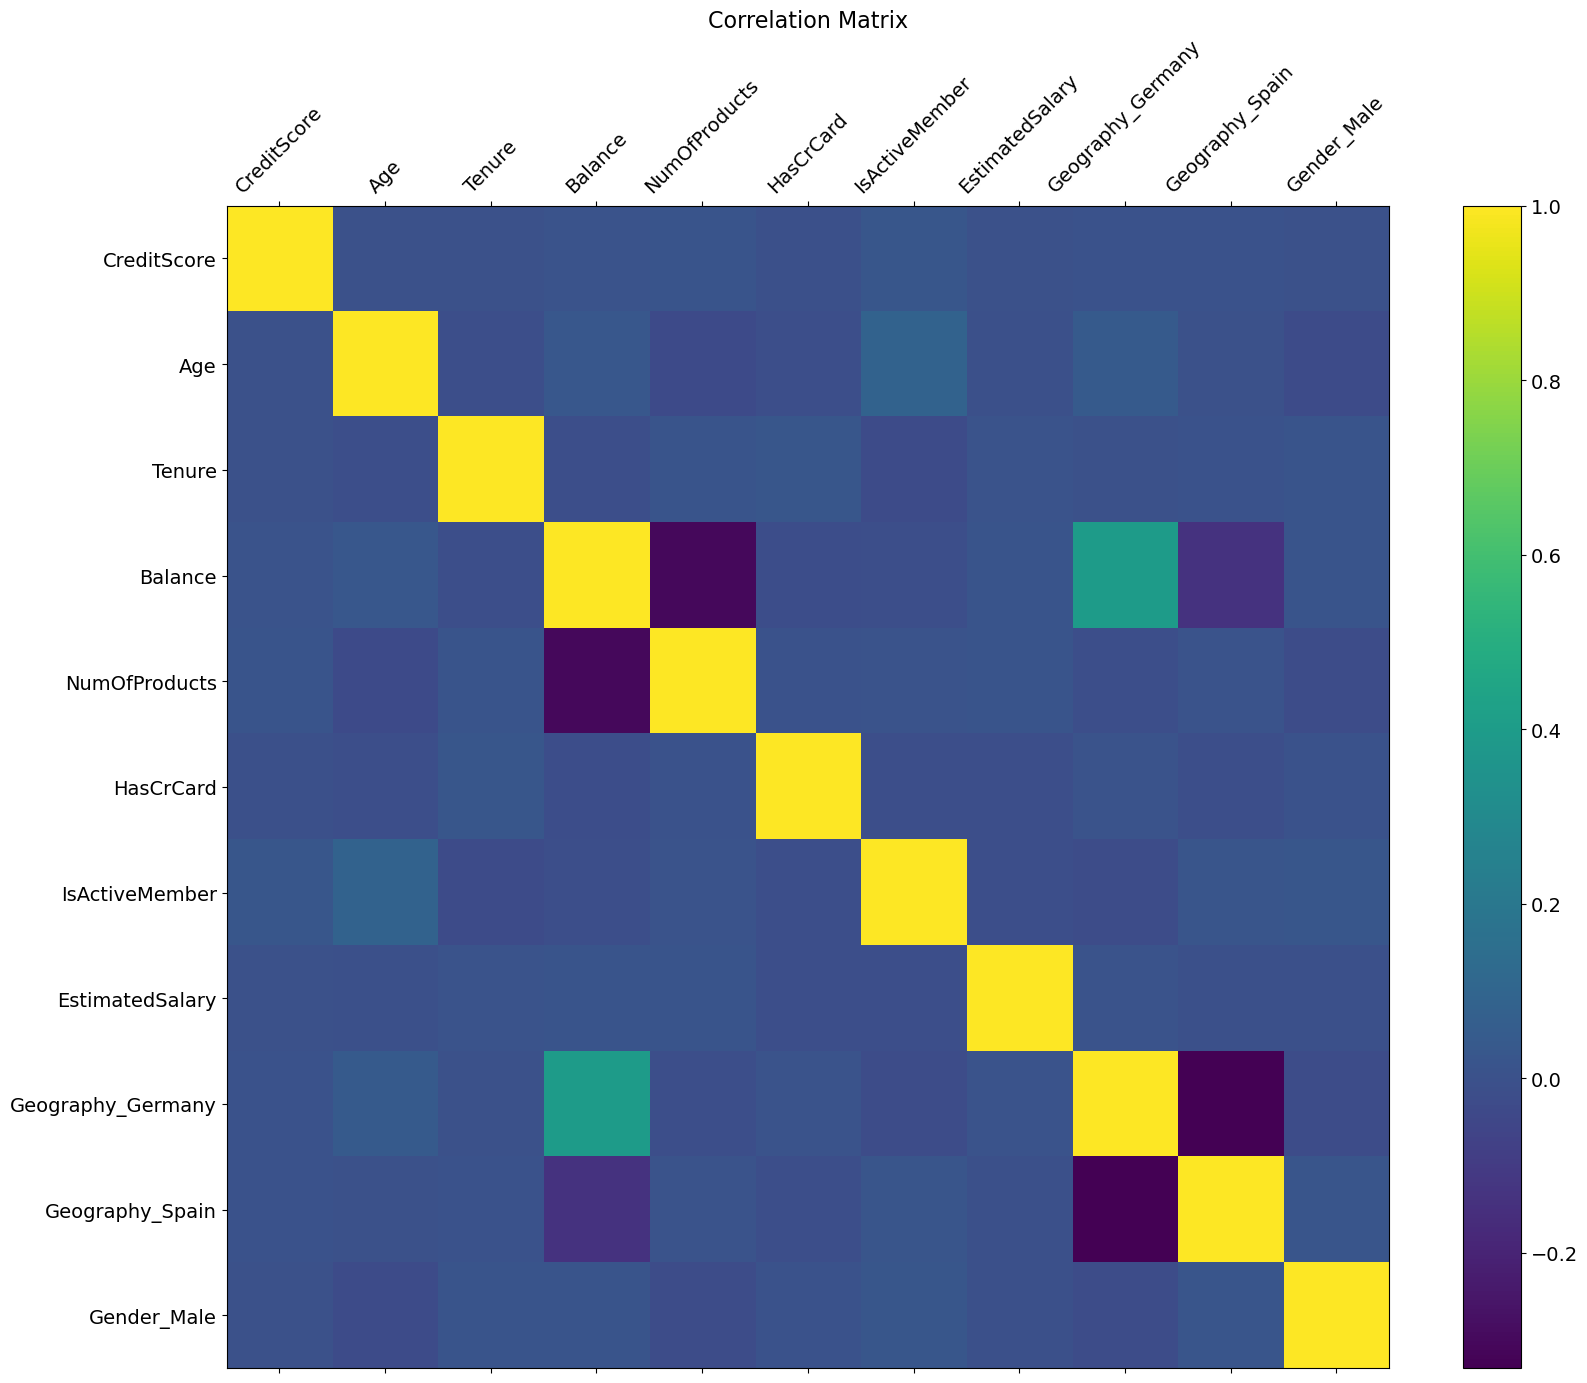

In [10]:
cf.correlationMatrix(predictors)

We can see from the matrix that the only significant correlation is between Balance and Geography_Germany features; we will recreate the dataset including Geography_France in place of Geography_Germany (excluded by drop_first=true) and re-check correlations.

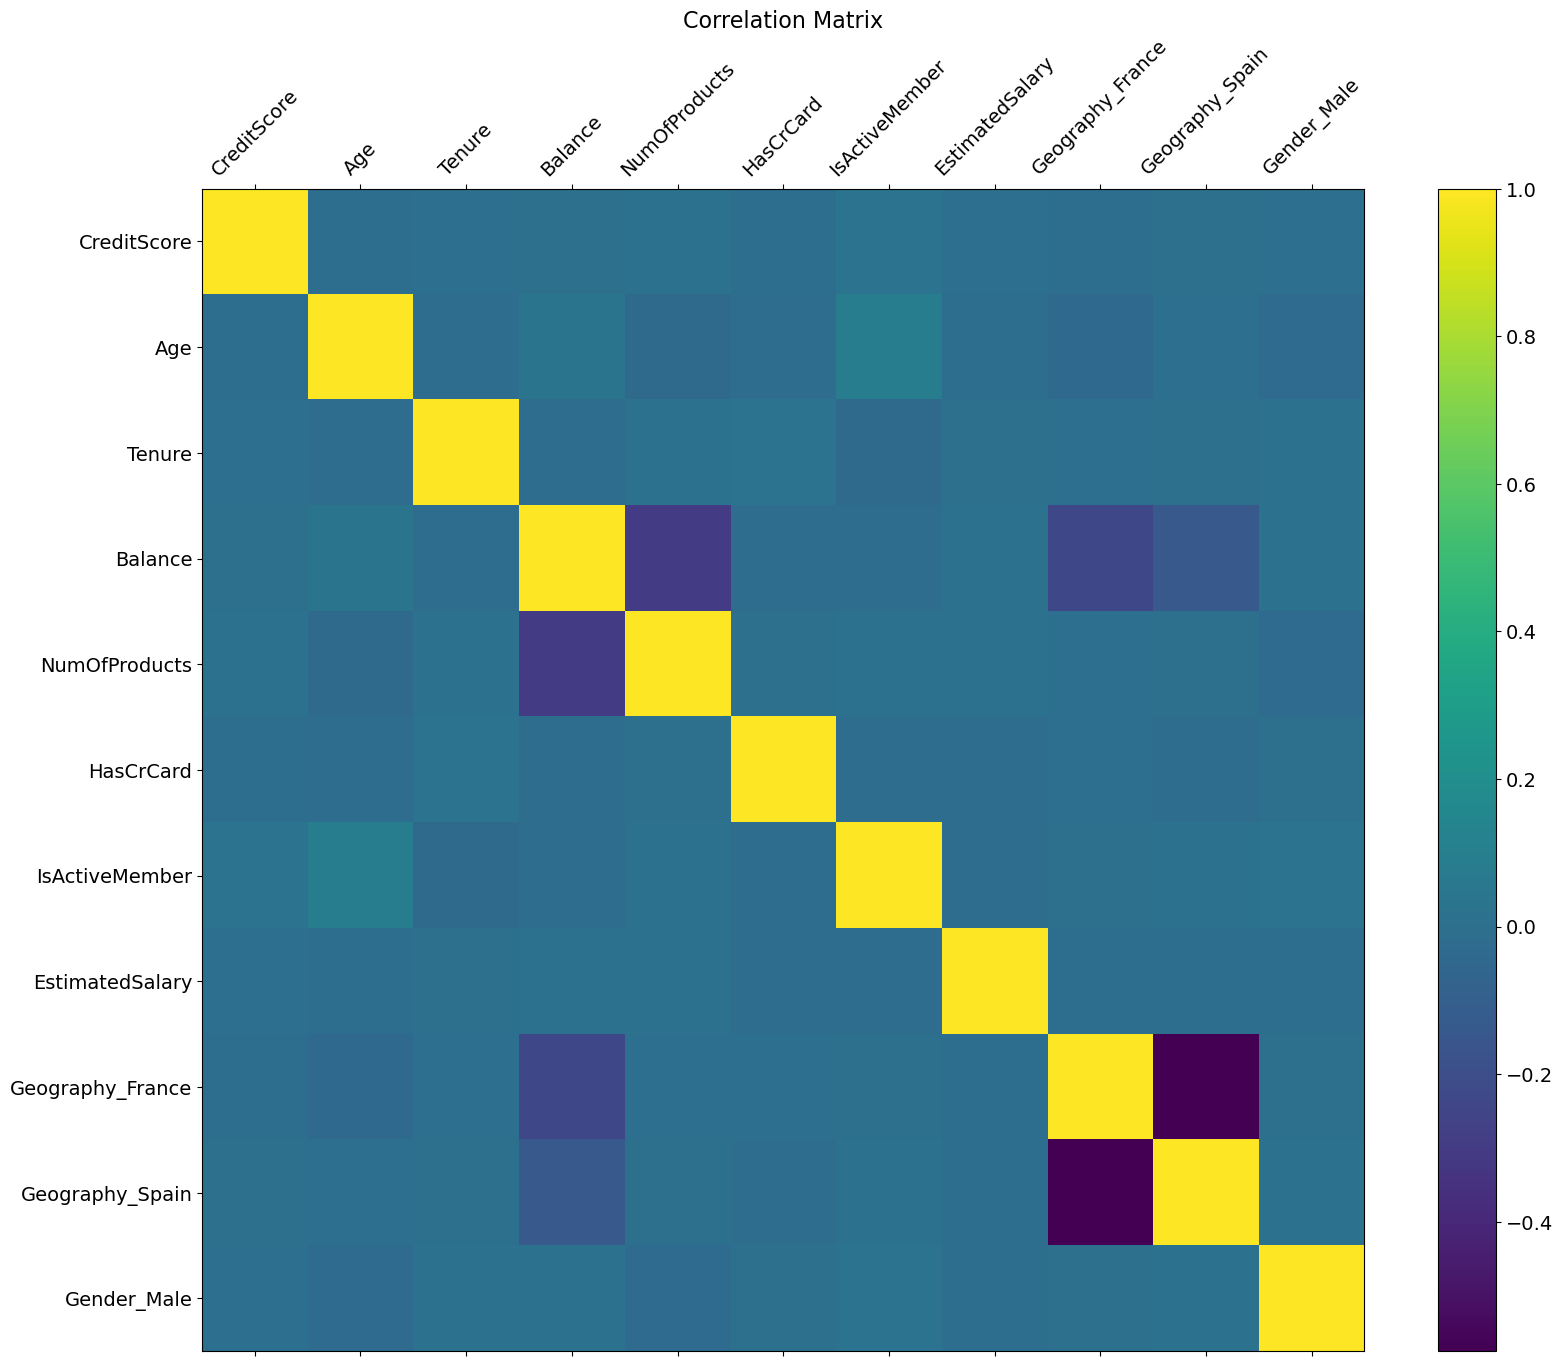

In [11]:
encodedData = pd.get_dummies(rawData)
encodedData.drop(columns=['Geography_Germany', 'Gender_Female'], inplace=True)
predictors = encodedData.drop(columns=['Exited'])
outcomes = encodedData['Exited']
cf.correlationMatrix(predictors)

That looks better, and we have not lost any Geographical data!

In [12]:
featureNames = predictors.columns
featureNames

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [ ]:
results, scores = cf.trainTestCycle(predictors,outcomes, featureNames)

Processing Logistic model:
Processing Forest model:
Processing Gradient model:
Grid Search...
Best Hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 50}
Random Search...
Best Hyperparameters: {'regressor__n_estimators': 100, 'regressor__max_depth': 20, 'regressor__learning_rate': 0.5}
Processing SVC model:
Grid Search...


In [ ]:
print(results)#['Logistic'])#['train'])

In [ ]:
results['Logistic']

In [ ]:
results['Forest']

In [ ]:
results['Gradient']

In [ ]:
results['SVC']

In [ ]:
def processOutput(myData):
    if type(myData) is str:
        print(myData)
    elif type(myData) is float:
        print(str(myData))
    elif type(myData) is int:
        print(str(myData))
    elif type(myData) is dict:
        for p1,p2 in myData.items():
            print(p1 + ": ")
            processOutput(myData)
    return

for model, data in results.items():
    print("Model: " + model)
    for paramName, paramValue in data.items():
        print("Optimisation: " + paramName)
        for p1,p2 in paramValue.items():
            print(p1 + ": ")
            processOutput(p2)
            #if type(p2) is str:
            #    print(p2)
            #elif type(p2) is float:
            #    print(str(p2))
            #elif type(p2) is int:
            #    print(str(p2))
            #elif type(p2) is dict:
            #    for p3,p4 in p2.items():
            #        print(p3 + ":")
            #        if type(p4) is str:
            #            print(p4)
            #        elif type(p4) is float:
            #            print(str(p4))
            #        elif type(p4) is int:
            #            print(str(p4))

In [ ]:
scores